1) ¿Qué son los entity embeddings y cómo se relacionan con las variables categóricas?

Se trata de un método de representación de variables categoricas que destaca por tener en cuenta la relación o similaridad entre las variables. El paper sugerido por la cátedra menciona que un gran problema en la aplicación práctica de redes neuronales es la "discontinuidad" de la data a procesar para sets de datos estructurados, los cuales pueden carecer cualquier tipo de continuidad, pero con entity embeddings este problema se puede aliviar ya que "revela la continuidad intrínseca de la data" lo cual facilita la aplicación exitosa de una red neuronal.

2) Explique la métrica utilizada en la competencia

Se utiliza RMSE, con la salvedad de que en esta competencia se normaliza el error al dividir la diferencia entre la predicción y el valor real por este último. Así, la métrica se inmuniza ante sesgos que surgirían por procesar las ventas de locales con más o menos ventas, ya que la magnitud del error es directamente proporcional a la magnitud de las ventas de los locales analizados, además de que los locales de más ventas taparían al aporte de los locales más pequeños y por ende la red no podría adaptarse adecuadamente a ellos, buscando adaptarse sólo a los de muchas ventas ya que es lo que minimizaría el error (y por ende sería la decisión óptima matemáticamente, pero incorrecta en la práctica).

Preprocesamiento de datos.

En el archivo 02-data-preprocess-ipynb se tomó la raw data y se la adaptó a un formato adecuado. Esto incluye darle alguna representación a valores NaN según a qué tipo de dato correspondan, formateo adecuado de fechas/meses/días, mapeo de datos (es decir, los joins entre diferentes tablas) y de nuevo un formateo de datos, esta vez de competitions y promos.

En el archivo 03-durations-preprocess.ipnynb, primero se ignora el tipo de feriado estatal indicando sólo si hay feriado o no. Luego, tanto para promos como para feriados estatales y escolares, se agregan y formatean tablas indicando cuanto falta para el próximo y cuanto tiempo transcurrió desde el último. 

In [60]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\Franco\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [61]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [62]:
from tensorflow.keras.utils import to_categorical

In [63]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [64]:
cat_vars = ['Store', 
            'DayOfWeek', 
            'Year', 
            'Month', 
            'Day', 
            'StateHoliday', 
#            'CompetitionMonthsOpen', 
#            'Promo2Weeks', 
            'StoreType', 
            'Assortment', 
#            'PromoInterval', 
#            'CompetitionOpenSinceYear',  
            'State', 
#            'Promo2SinceYear',
            'Week', 
            'Events', 
#            'Promo_fw', 
#            'Promo_bw', 
            'StateHoliday_bool_fw',
            'StateHoliday_bool_bw', 
            'SchoolHoliday_fw', 
            'SchoolHoliday_bw'
]

#cat_vars = ['Store', 'DayOfWeek']

In [65]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
#contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [66]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [67]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
StoreType,4
Assortment,3
State,12
Week,52


# Asignación de dimensión de embeddings

In [68]:
cat_var_dict = {
    'Store': 1115, 'DayOfWeek': 7, 'Year': 3, 'Month': 12, 'Week': 52, 'Day': 31,  'Events': 22,
    'State': 12,  'StoreType': 4,  'Assortment': 3,
    'PromoInterval': 4,
    'Promo2SinceYear': 8,
    'Promo2Weeks': 26,
    'CompetitionMonthsOpen': 25,
    'CompetitionOpenSinceYear': 21,
    'Promo_fw': 6,'Promo_bw': 6,
    'StateHoliday': 4, 'StateHoliday_bool_fw': 3, 'StateHoliday_bool_bw': 3, 
    'SchoolHoliday_fw': 8,'SchoolHoliday_bw': 8}

In [69]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 1115 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 7 7 [0 1 2 3 4 5 6]

Year 3 3 [0 1 2]

Month 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 31 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 4 4 [0 1 2 3]

StoreType 4 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

State 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 52 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 22 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

StateHoliday_bool_fw 3 3 [0 1 2]

StateHoliday_bool_bw 3 3 [0 1 2]

SchoolHoliday_fw 8 8 [0 1 2 3 4 5 6 7]

SchoolHoliday_bw 8 8 [0 1 2 3 4 5 6 7]



# Definición de modelo

In [70]:
add_customers = True
log_output = True
output_activation = 'linear'

In [71]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [72]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [73]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [74]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [75]:
first_hidden_units = 1600
second_hidden_units = 800
l2_lambda = 1e-4
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

activation_csv = "relu"

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [76]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [77]:
# Descomentar para ver
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [78]:
model.save_weights('initial_weights.hdf5')

In [79]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [80]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [81]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [82]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

c:\Users\Franco\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\Franco\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [83]:
from tensorflow.keras import backend as K

In [84]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [85]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [86]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [87]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [88]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
     y_mean = df_train[y_out_columns].mean().values
     y_std = df_train[y_out_columns].std().values
     y_train = (df_train[y_out_columns].values - y_mean)/y_std
     y_val = (df_val[y_out_columns].values - y_mean)/y_std
     y_max = df_train[y_out_columns].max().values
     y_train = df_train[y_out_columns].values/y_max
     y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [89]:
lr = 0.00008
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

C:\Users\Franco\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [90]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [91]:
epochs = 6
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/6

Epoch 1: val_Sales_mse improved from inf to 0.00047, saving model to bestmodel.hdf5
6361/6361 - 465s - loss: 0.0564 - Sales_loss: 0.0013 - Customers_loss: 0.0014 - Sales_mse: 0.0013 - Sales_rmspe: 0.0303 - Customers_mse: 0.0014 - Customers_rmspe: 0.0365 - val_loss: 0.0044 - val_Sales_loss: 4.6517e-04 - val_Customers_loss: 3.8558e-04 - val_Sales_mse: 4.6517e-04 - val_Sales_rmspe: 0.0257 - val_Customers_mse: 3.8558e-04 - val_Customers_rmspe: 0.0266 - 465s/epoch - 73ms/step
Epoch 2/6

Epoch 2: val_Sales_mse improved from 0.00047 to 0.00020, saving model to bestmodel.hdf5
6361/6361 - 471s - loss: 0.0015 - Sales_loss: 2.3502e-04 - Customers_loss: 2.7311e-04 - Sales_mse: 2.3502e-04 - Sales_rmspe: 0.0189 - Customers_mse: 2.7311e-04 - Customers_rmspe: 0.0231 - val_loss: 6.8500e-04 - val_Sales_loss: 1.9809e-04 - val_Customers_loss: 1.9849e-04 - val_Sales_mse: 1.9809e-04 - val_Sales_rmspe: 0.0168 - val_Customers_mse: 1.9849e-04 - val_Customers_rmspe: 0.0189 - 471s/epoch - 74ms/step
Ep

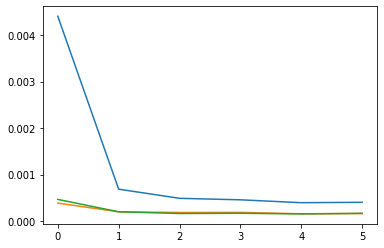

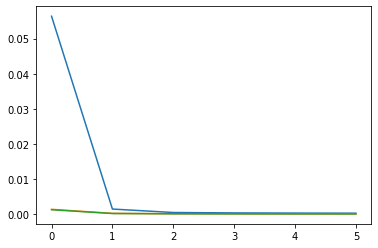

In [92]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['Customers_mse'])
plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [93]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 11s 11ms/step - loss: 4.0240e-04 - Sales_loss: 1.6624e-04 - Customers_loss: 1.6016e-04 - Sales_mse: 1.6624e-04 - Sales_rmspe: 0.0151 - Customers_mse: 1.6016e-04 - Customers_rmspe: 0.0167


[0.00040240061935037374,
 0.00016624099225737154,
 0.00016015525034163147,
 0.00016624099225737154,
 0.015134075656533241,
 0.00016015525034163147,
 0.016733329743146896]

In [94]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 11s 11ms/step - loss: 3.9463e-04 - Sales_loss: 1.5292e-04 - Customers_loss: 1.5537e-04 - Sales_mse: 1.5292e-04 - Sales_rmspe: 0.0145 - Customers_mse: 1.5537e-04 - Customers_rmspe: 0.0164


[0.00039462672430090606,
 0.0001529221044620499,
 0.00015537028957623988,
 0.0001529221044620499,
 0.014488114975392818,
 0.00015537028957623988,
 0.016444150358438492]

In [95]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

944/944 [==============================] - 11s 11ms/step - loss: 3.9463e-04 - Sales_loss: 1.5292e-04 - Customers_loss: 1.5537e-04 - Sales_mse: 1.5292e-04 - Sales_rmspe: 0.0145 - Customers_mse: 1.5537e-04 - Customers_rmspe: 0.0164


[0.00039462672430090606,
 0.0001529221044620499,
 0.00015537028957623988,
 0.0001529221044620499,
 0.014488114975392818,
 0.00015537028957623988,
 0.016444150358438492]

In [96]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
         y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 8s 6ms/step


In [97]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.14287378497517866

In [98]:
y_pred_test[:10]

array([4576.1646, 7485.306 , 9244.777 , 6879.609 , 7284.764 , 5750.376 ,
       8229.739 , 8172.2466, 5142.682 , 5754.524 ], dtype=float32)

# Baseline

In [99]:
import pandas as pd
sample_csv = pd.read_csv('C:\\Users\\Franco\\Desktop\\kaggle-rossmann-master\\rossmann\\sample_submission.csv')

In [100]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [101]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [102]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [103]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [104]:
sample_csv['Sales'] = df_test['Sales']

In [105]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [106]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Submit a la competición

In [107]:
import datetime
import random
random.seed()


In [108]:

sample_csv = pd.read_csv('C:\\Users\\Franco\\Desktop\\kaggle-rossmann-master\\rossmann\\sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{activation_csv}-{first_hidden_units}-{second_hidden_units}-{epochs}-{batch_size}-{lr}--{random.randint(0,9999999)}.csv', index=False)


# Analisis de embedings

In [109]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 7)


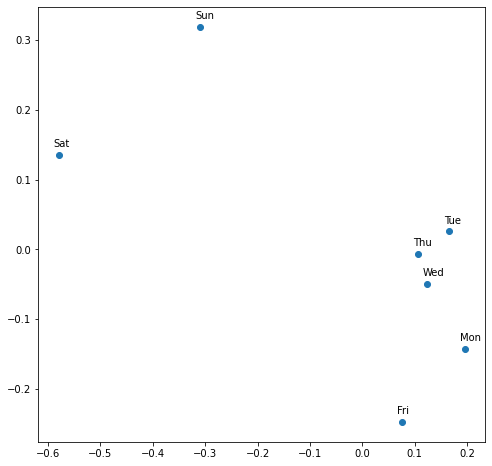

In [110]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(12, 12)


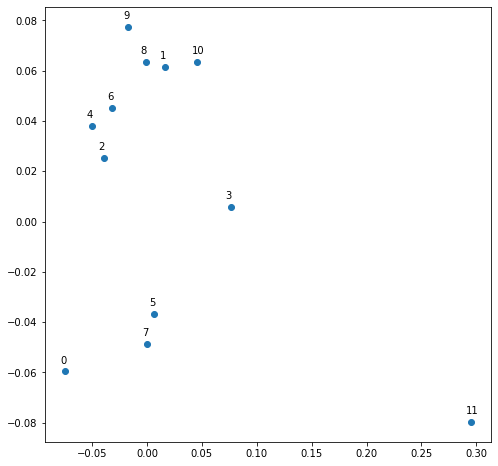

In [111]:
plot_embed('Month_Embed', list(range(12)))

In [112]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [113]:
#day_of_week_embedding.shape

In [114]:
#tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
#Y = tsne.fit_transform(day_of_week_embedding)
#names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
#plt.figure(figsize=(8,8))
#plt.scatter(-Y[:, 0], -Y[:, 1])
#for i, txt in enumerate(names):
#    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [115]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'StoreType',
 'Assortment',
 'State',
 'Week',
 'Events',
 'StateHoliday_bool_fw',
 'StateHoliday_bool_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

## Store embeddings

In [116]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [117]:
submodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [118]:
submodel.save('embeddings_model.hdf5')